# Parte 1/10: Importaciones y configuración global

In [29]:
# ----------------------------
# Importación de librerías optimizadas
# ----------------------------
import numpy as np
import pandas as pd
from scipy import stats
import missingno as msno

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Preprocesamiento y modelado
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Modelos adicionales
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Evaluación de modelos
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                          accuracy_score, classification_report, confusion_matrix,
                          roc_curve, auc, precision_score, recall_score, f1_score)

# Producción
import streamlit as st
import joblib

# Configuración global
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [30]:
# Parte 2/10: Clase principal y constructor

class AutomovilesModelEnhanced:
    def __init__(self, ruta_dataset):
        self.ruta_dataset = ruta_dataset
        self.df = None
        self.modelos_regresion = {}
        self.modelos_clasificacion = {}
        self.mejor_modelo_reg = None
        self.mejor_modelo_clf = None
        self.metricas_comparativas = {}    
    
 # Parte 3/10: Método limpiar_datos   
    def limpiar_datos(self):
        """Limpia el dataset eliminando valores NaN problemáticos"""
        print("🧹 LIMPIANDO DATOS...")
        
        # Mostrar información inicial
        print(f"Tamaño inicial del dataset: {self.df.shape}")
        print("Valores NaN por columna:")
        print(self.df.isna().sum())
        
        # Eliminar columnas con demasiados NaN (>50%)
        columnas_a_eliminar = [
            col for col in self.df.columns 
            if self.df[col].isna().sum() / len(self.df) > 0.5
        ]
        if columnas_a_eliminar:
            print(f"Eliminando columnas con >50% NaN: {columnas_a_eliminar}")
            self.df = self.df.drop(columns=columnas_a_eliminar)
        
        # Eliminar filas con demasiados NaN (>50% de columnas)
        filas_a_eliminar = self.df.isna().sum(axis=1) / self.df.shape[1] > 0.5
        if filas_a_eliminar.any():
            print(f"Eliminando {filas_a_eliminar.sum()} filas con >50% NaN")
            self.df = self.df[~filas_a_eliminar]
        
        print(f"Tamaño después de limpieza: {self.df.shape}")
        return self.df


# Parte 4/10: Método cargar_datos


    def cargar_datos(self):
        """Carga y muestra información básica del dataset"""
        self.df = pd.read_csv(self.ruta_dataset)
        print(f"Dataset cargado: {self.df.shape[0]} filas × {self.df.shape[1]} columnas")
        
        # Aplicar limpieza
        self.limpiar_datos()
        
        print("\nPrimeras 5 filas del dataset:")
        print(self.df.head())
        print("\nColumnas disponibles:")
        print(self.df.columns.tolist())
        print("\nValores NaN después de limpieza:")
        print(self.df.isna().sum())
        
        return self.df

# Parte 5/10: Método analizar_datos 

    def preparar_datos(self):
        """Prepara los datos para modelado creando variables objetivo"""
        # Verificar qué columnas de precio existen
        columnas_precio = [col for col in self.df.columns if 'price' in col.lower() or 'precio' in col.lower()]
        print(f"Columnas de precio encontradas: {columnas_precio}")
        
        # Seleccionar columna de precio
        if 'Price_Max_log' in self.df.columns:
            columna_precio = 'Price_Max_log'
        elif 'Price_Max' in self.df.columns:
            columna_precio = 'Price_Max'
        elif columnas_precio:
            columna_precio = columnas_precio[0]
        else:
            columnas_numericas = self.df.select_dtypes(include=['int64', 'float64']).columns
            columna_precio = columnas_numericas[0] if len(columnas_numericas) > 0 else self.df.columns[0]
        
        print(f"Usando columna de precio: {columna_precio}")
        
        # Eliminar NaN en columna objetivo
        n_antes = len(self.df)
        self.df = self.df.dropna(subset=[columna_precio])
        print(f"Se eliminaron {n_antes - len(self.df)} filas con NaN en {columna_precio}")
        
        # Crear variable binaria de clasificación
        if 'Precio_Alto' not in self.df.columns:
            precio_mediano = self.df[columna_precio].median()
            self.df['Precio_Alto'] = (self.df[columna_precio] > precio_mediano).astype(int)
            print(f"✅ Variable Precio_Alto creada (umbral: {precio_mediano:.2f})")
        
        # Definir objetivos
        columnas_a_excluir = [columna_precio, 'Precio_Alto']
        if 'Precio_Categoria' in self.df.columns:
            columnas_a_excluir.append('Precio_Categoria')
            
        caracteristicas = self.df.drop(columnas_a_excluir, axis=1)
        objetivo_reg = self.df[columna_precio]
        objetivo_clf = self.df['Precio_Alto']
        
        # Verificar NaN en objetivos
        print(f"NaN en objetivo_reg: {objetivo_reg.isna().sum()}")
        print(f"NaN en objetivo_clf: {objetivo_clf.isna().sum()}")
        
        if objetivo_reg.isna().sum() > 0 or objetivo_clf.isna().sum() > 0:
            mask = objetivo_reg.notna() & objetivo_clf.notna()
            caracteristicas = caracteristicas[mask]
            objetivo_reg = objetivo_reg[mask]
            objetivo_clf = objetivo_clf[mask]
            print(f"✅ Filas después de eliminar NaN en objetivos: {len(objetivo_reg)}")
        
        # Identificar columnas numéricas y categóricas
        columnas_numericas = caracteristicas.select_dtypes(include=['int64', 'float64']).columns.tolist()
        columnas_categoricas = caracteristicas.select_dtypes(include=['object', 'category']).columns.tolist()
        
        print(f"✅ Características: {caracteristicas.shape}")
        print(f"✅ Variable objetivo regresión: {objetivo_reg.shape}")
        print(f"✅ Variable objetivo clasificación: {objetivo_clf.shape}")
        print(f"✅ Columnas numéricas: {len(columnas_numericas)}")
        print(f"✅ Columnas categóricas: {len(columnas_categoricas)}")
        
        return caracteristicas, objetivo_reg, objetivo_clf, columnas_numericas, columnas_categoricas

# Parte 6/10: Métodos de preprocesamiento

    def crear_pipeline_preprocesamiento(self, columnas_numericas, columnas_categoricas):
        """Crea el pipeline de preprocesamiento"""
        transformador_numerico = Pipeline(steps=[
            ('imputador', SimpleImputer(strategy='median')),
            ('escalador', StandardScaler())
        ])

        transformador_categorico = Pipeline(steps=[
            ('imputador', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]) if columnas_categoricas else 'passthrough'

        preprocesador = ColumnTransformer(transformers=[
            ('numerico', transformador_numerico, columnas_numericas),
            ('categorico', transformador_categorico, columnas_categoricas)
        ])

        print("✅ Pipeline de preprocesamiento creado")
        return preprocesador

    def crear_modelos_regresion(self, preprocesador):
        """Crea múltiples modelos de regresión"""
        modelos = {
            'Random Forest': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RANDOM_STATE))
            ]),
            'SVM': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', SVR(kernel='rbf', C=1.0))
            ]),
            'Linear Regression': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', LinearRegression())
            ]),
            'Decision Tree': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE))
            ]),
            'K-Neighbors': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', KNeighborsRegressor(n_neighbors=5))
            ])
        }
        return modelos

    def crear_modelos_clasificacion(self, preprocesador):
        """Crea múltiples modelos de clasificación"""
        modelos = {
            'Random Forest': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=RANDOM_STATE))
            ]),
            'SVM': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', SVC(kernel='rbf', C=1.0, probability=True, random_state=RANDOM_STATE))
            ]),
            'Logistic Regression': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', LogisticRegression(random_state=RANDOM_STATE))
            ]),
            'Naive Bayes': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', GaussianNB())
            ]),
            'LDA': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', LinearDiscriminantAnalysis())
            ]),
            'Decision Tree': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE))
            ]),
            'K-Neighbors': Pipeline([
                ('preprocesador', preprocesador),
                ('modelo', KNeighborsClassifier(n_neighbors=5))
            ])
        }
        return modelos


# Parte 7/10: Métodos de evaluación

    def calcular_metricas_regresion(self, y_true, y_pred, modelo_nombre="Modelo"):
        """Calcula métricas detalladas para regresión"""
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Error porcentual absoluto medio
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100

        # Error máximo
        max_error = np.max(np.abs(y_true - y_pred))

        # R2 ajustado
        n = len(y_true)
        p = 1  # Simplificado
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else r2

        metricas = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'R² Ajustado': r2_adj,
            'MAPE (%)': mape,
            'Error Máximo': max_error
        }

        print(f"\n📊 MÉTRICAS DETALLADAS - {modelo_nombre.upper()}")
        print("="*50)
        for key, value in metricas.items():
            print(f"{key}: {value:.4f}")

        return metricas

    def calcular_metricas_clasificacion(self, y_true, y_pred, y_proba=None, modelo_nombre="Modelo"):
        """Calcula métricas detalladas para clasificación"""
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metricas = {
            'Exactitud': accuracy,
            'Precisión': precision,
            'Recall': recall,
            'F1-Score': f1
        }

        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            roc_auc = auc(fpr, tpr)
            metricas['AUC-ROC'] = roc_auc

        print(f"\n📊 MÉTRICAS DETALLADAS - {modelo_nombre.upper()}")
        print("="*50)
        for key, value in metricas.items():
            print(f"{key}: {value:.4f}")

        print(f"\n📋 REPORTE DE CLASIFICACIÓN:")
        print(classification_report(y_true, y_pred, target_names=['Precio Bajo', 'Precio Alto']))

        return metricas

    def dividir_datos(self, X, y_reg, y_clf):
        """Divide los datos en conjuntos de entrenamiento y prueba"""
        X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
            X, y_reg, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_clf
        )

        X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
            X, y_clf, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_clf
        )

        print(f"\n📊 DIVISIÓN DE DATOS:")
        print(f"REGRESIÓN - Entrenamiento: {X_train_reg.shape[0]}, Prueba: {X_test_reg.shape[0]}")
        print(f"CLASIFICACIÓN - Entrenamiento: {X_train_clf.shape[0]}, Prueba: {X_test_clf.shape[0]}")

        return (X_train_reg, X_test_reg, y_train_reg, y_test_reg,
                X_train_clf, X_test_clf, y_train_clf, y_test_clf)


# Parte 8/10: Métodos de entrenamiento

    def evaluar_modelos_regresion(self, modelos, X_train, y_train, X_test, y_test):
        """Evalúa múltiples modelos de regresión"""
        resultados = {}

        for nombre, modelo in modelos.items():
            print(f"\n🎯 ENTRENANDO MODELO: {nombre}")
            print("-" * 30)

            # Entrenar modelo
            modelo.fit(X_train, y_train)

            # Predicciones
            y_train_pred = modelo.predict(X_train)
            y_test_pred = modelo.predict(X_test)

            # Métricas detalladas
            print(f"📈 RESULTADOS ENTRENAMIENTO:")
            metricas_train = self.calcular_metricas_regresion(y_train, y_train_pred, f"{nombre} - Entrenamiento")

            print(f"📊 RESULTADOS PRUEBA:")
            metricas_test = self.calcular_metricas_regresion(y_test, y_test_pred, f"{nombre} - Prueba")

            # Diferencia de overfitting
            diff_rmse = abs(metricas_train['RMSE'] - metricas_test['RMSE'])
            print(f"📉 Diferencia RMSE (Overfitting): {diff_rmse:.4f}")

            resultados[nombre] = {
                'modelo': modelo,
                'metricas_train': metricas_train,
                'metricas_test': metricas_test,
                'overfitting_rmse': diff_rmse,
                'y_test_pred': y_test_pred
            }

        return resultados

    def evaluar_modelos_clasificacion(self, modelos, X_train, y_train, X_test, y_test):
        """Evalúa múltiples modelos de clasificación"""
        resultados = {}

        for nombre, modelo in modelos.items():
            print(f"\n🎯 ENTRENANDO MODELO: {nombre}")
            print("-" * 30)

            # Entrenar modelo
            modelo.fit(X_train, y_train)

            # Predicciones
            y_train_pred = modelo.predict(X_train)
            y_test_pred = modelo.predict(X_test)

            # Probabilidades para AUC-ROC
            y_test_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, 'predict_proba') else None

            # Métricas detalladas
            print(f"📈 RESULTADOS ENTRENAMIENTO:")
            metricas_train = self.calcular_metricas_clasificacion(y_train, y_train_pred, None, f"{nombre} - Entrenamiento")

            print(f"📊 RESULTADOS PRUEBA:")
            metricas_test = self.calcular_metricas_clasificacion(y_test, y_test_pred, y_test_proba, f"{nombre} - Prueba")

            # Matriz de confusión
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_test_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=['Precio Bajo', 'Precio Alto'],
                      yticklabels=['Precio Bajo', 'Precio Alto'])
            plt.title(f'Matriz de Confusión - {nombre}')
            plt.ylabel('Valor Real')
            plt.xlabel('Valor Predicho')
            plt.show()

            resultados[nombre] = {
                'modelo': modelo,
                'metricas_train': metricas_train,
                'metricas_test': metricas_test,
                'y_test_pred': y_test_pred,
                'y_test_proba': y_test_proba
            }

        return resultados

# Parte 9/10: Métodos de comparación e interfaz

    def comparar_modelos_regresion(self, resultados):
        """Compara los resultados de todos los modelos de regresión"""
        print("\n🏆 COMPARACIÓN DE MODELOS - REGRESIÓN")
        print("="*60)

        comparacion = []
        for nombre, resultado in resultados.items():
            comparacion.append({
                'Modelo': nombre,
                'RMSE Test': resultado['metricas_test']['RMSE'],
                'MAE Test': resultado['metricas_test']['MAE'],
                'R² Test': resultado['metricas_test']['R²'],
                'MAPE Test': resultado['metricas_test']['MAPE (%)'],
                'Overfitting RMSE': resultado['overfitting_rmse']
            })

        df_comparacion = pd.DataFrame(comparacion)
        df_comparacion = df_comparacion.sort_values('R² Test', ascending=False)

        print(df_comparacion.to_string(index=False))

        # Gráfico comparativo
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # R² comparativo
        modelos = df_comparacion['Modelo']
        r2_scores = df_comparacion['R² Test']

        axes[0, 0].bar(modelos, r2_scores, color='darkblue')
        axes[0, 0].set_title('Comparación de R² entre Modelos')
        axes[0, 0].set_ylabel('R² Score')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # RMSE comparativo
        rmse_scores = df_comparacion['RMSE Test']
        axes[0, 1].bar(modelos, rmse_scores, color='darkblue')
        axes[0, 1].set_title('Comparación de RMSE entre Modelos')
        axes[0, 1].set_ylabel('RMSE')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Overfitting comparativo
        overfitting_scores = df_comparacion['Overfitting RMSE']
        axes[1, 0].bar(modelos, overfitting_scores, color='darkblue')
        axes[1, 0].set_title('Overfitting (Diferencia RMSE) entre Modelos')
        axes[1, 0].set_ylabel('Diferencia RMSE')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # MAPE comparativo
        mape_scores = df_comparacion['MAPE Test']
        axes[1, 1].bar(modelos, mape_scores, color='darkblue')
        axes[1, 1].set_title('MAPE (%) entre Modelos')
        axes[1, 1].set_ylabel('MAPE (%)')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        return df_comparacion

    def comparar_modelos_clasificacion(self, resultados):
        """Compara los resultados de todos los modelos de clasificación"""
        print("\n🏆 COMPARACIÓN DE MODELOS - CLASIFICACIÓN")
        print("="*60)

        comparacion = []
        for nombre, resultado in resultados.items():
            comparacion.append({
                'Modelo': nombre,
                'Exactitud Test': resultado['metricas_test']['Exactitud'],
                'Precisión Test': resultado['metricas_test']['Precisión'],
                'Recall Test': resultado['metricas_test']['Recall'],
                'F1-Score Test': resultado['metricas_test']['F1-Score'],
                'AUC-ROC Test': resultado['metricas_test'].get('AUC-ROC', 'N/A')
            })

        df_comparacion = pd.DataFrame(comparacion)
        df_comparacion = df_comparacion.sort_values('Exactitud Test', ascending=False)

        print(df_comparacion.to_string(index=False))

        return df_comparacion





# Parte 10/10: Métodos finales y ejecución principal

🎯 INICIANDO ANÁLISIS COMPLETO MEJORADO
Dataset cargado: 1218 filas × 15 columnas
Columnas de precio encontradas: ['Price_Min', 'Price_Max']
Usando columna de precio: Price_Max
Se eliminaron 1 filas con NaN en Price_Max
✅ Variable Precio_Alto creada (umbral: 43590.00)
NaN en objetivo_reg: 0
NaN en objetivo_clf: 0
✅ Características: (1217, 14)
✅ Variable objetivo regresión: (1217,)
✅ Variable objetivo clasificación: (1217,)
✅ Columnas numéricas: 10
✅ Columnas categóricas: 4
✅ Pipeline de preprocesamiento creado

📊 DIVISIÓN DE DATOS:
REGRESIÓN - Entrenamiento: 973, Prueba: 244
CLASIFICACIÓN - Entrenamiento: 973, Prueba: 244

🎯 MODELOS DE REGRESIÓN - Comparación Múltiple

🎯 ENTRENANDO MODELO: Random Forest
------------------------------
📈 RESULTADOS ENTRENAMIENTO:

📊 MÉTRICAS DETALLADAS - RANDOM FOREST - ENTRENAMIENTO
RMSE: 165502.8072
MAE: 9851.1189
R²: 0.9550
R² Ajustado: 0.9550
MAPE (%): 1.6423
Error Máximo: 4848000.0000
📊 RESULTADOS PRUEBA:

📊 MÉTRICAS DETALLADAS - RANDOM FOREST - PRUE

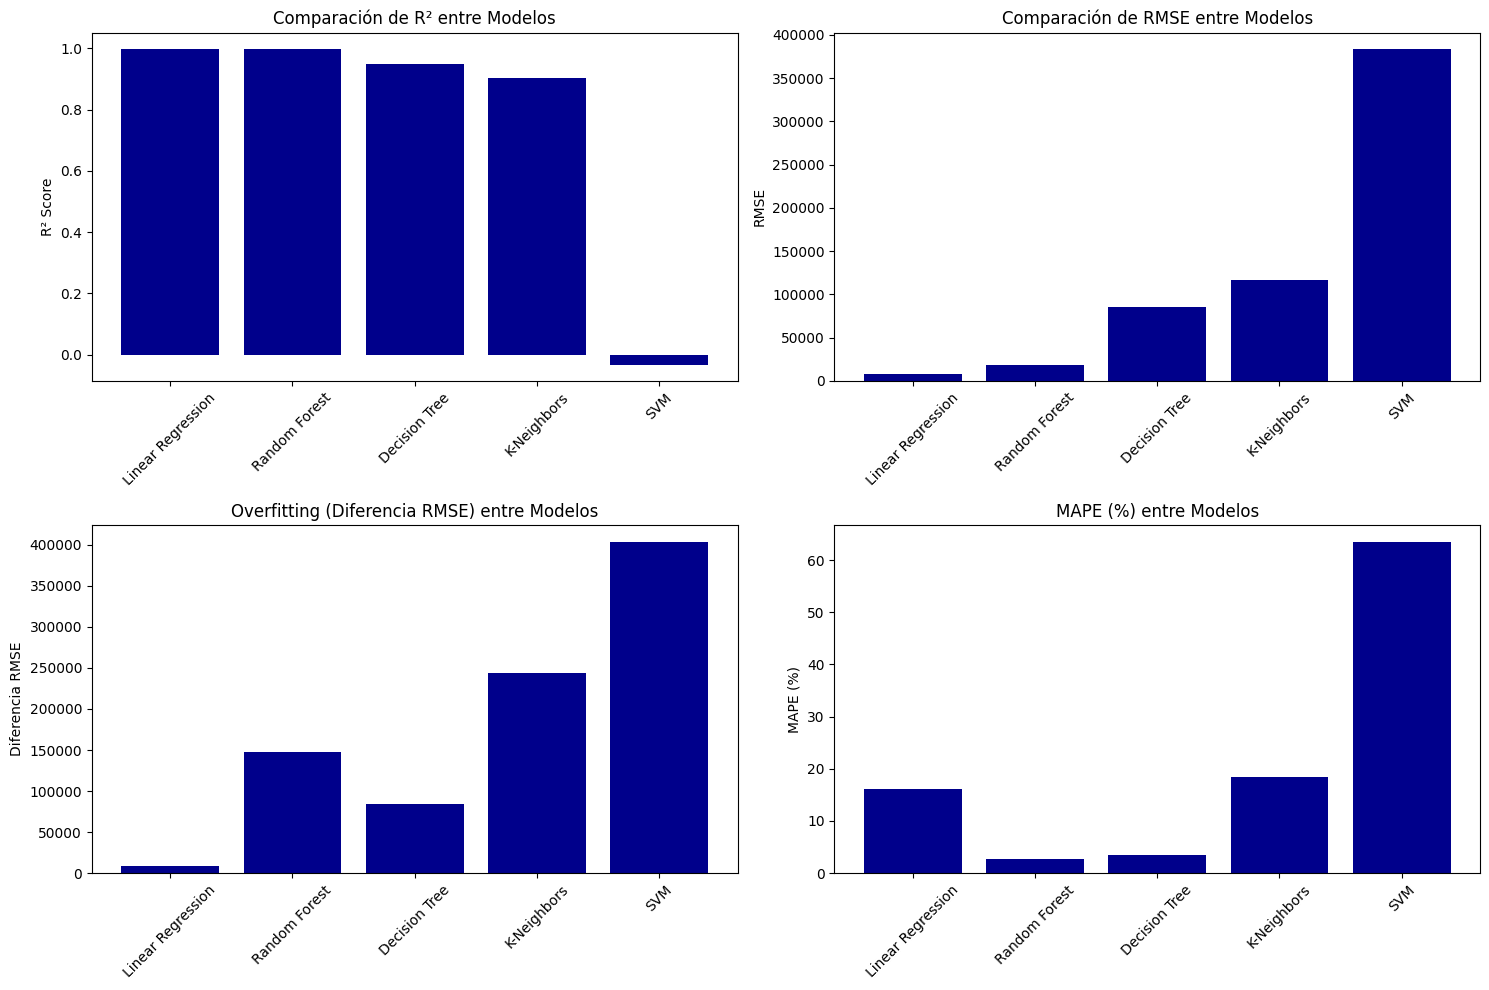


🎯 MODELOS DE CLASIFICACIÓN - Comparación Múltiple

🎯 ENTRENANDO MODELO: Random Forest
------------------------------
📈 RESULTADOS ENTRENAMIENTO:

📊 MÉTRICAS DETALLADAS - RANDOM FOREST - ENTRENAMIENTO
Exactitud: 0.9723
Precisión: 0.9723
Recall: 0.9723
F1-Score: 0.9723

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.97      0.98      0.97       487
 Precio Alto       0.98      0.97      0.97       486

    accuracy                           0.97       973
   macro avg       0.97      0.97      0.97       973
weighted avg       0.97      0.97      0.97       973

📊 RESULTADOS PRUEBA:

📊 MÉTRICAS DETALLADAS - RANDOM FOREST - PRUEBA
Exactitud: 0.9344
Precisión: 0.9345
Recall: 0.9344
F1-Score: 0.9344
AUC-ROC: 0.9887

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.93      0.94      0.93       122
 Precio Alto       0.94      0.93      0.93       122

    accuracy                 

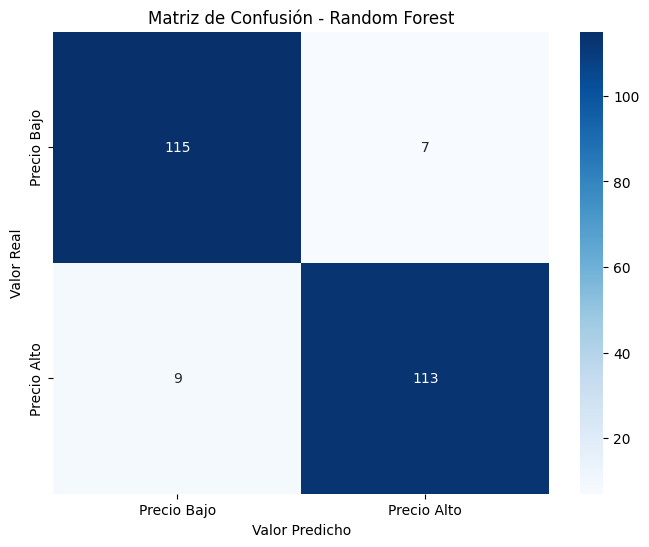


🎯 ENTRENANDO MODELO: SVM
------------------------------
📈 RESULTADOS ENTRENAMIENTO:

📊 MÉTRICAS DETALLADAS - SVM - ENTRENAMIENTO
Exactitud: 0.9496
Precisión: 0.9497
Recall: 0.9496
F1-Score: 0.9496

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.95      0.95      0.95       487
 Precio Alto       0.95      0.94      0.95       486

    accuracy                           0.95       973
   macro avg       0.95      0.95      0.95       973
weighted avg       0.95      0.95      0.95       973

📊 RESULTADOS PRUEBA:

📊 MÉTRICAS DETALLADAS - SVM - PRUEBA
Exactitud: 0.8811
Precisión: 0.8832
Recall: 0.8811
F1-Score: 0.8810
AUC-ROC: 0.9580

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.85      0.92      0.89       122
 Precio Alto       0.91      0.84      0.88       122

    accuracy                           0.88       244
   macro avg       0.88      0.88      0.88       244
we

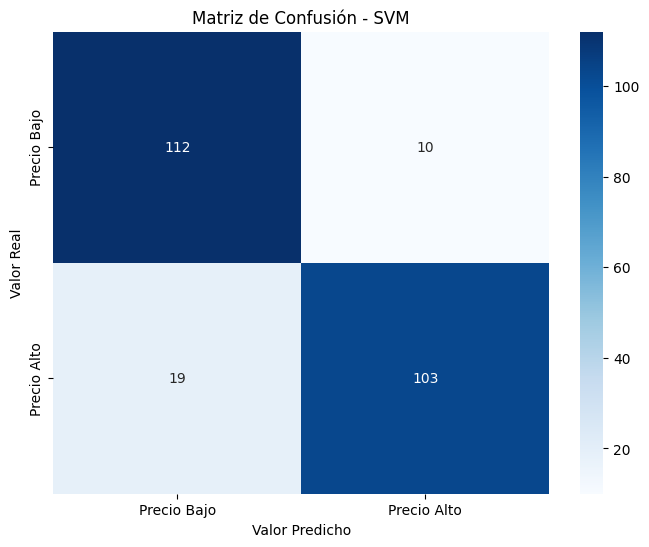


🎯 ENTRENANDO MODELO: Logistic Regression
------------------------------
📈 RESULTADOS ENTRENAMIENTO:

📊 MÉTRICAS DETALLADAS - LOGISTIC REGRESSION - ENTRENAMIENTO
Exactitud: 0.9599
Precisión: 0.9600
Recall: 0.9599
F1-Score: 0.9599

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.95      0.97      0.96       487
 Precio Alto       0.97      0.95      0.96       486

    accuracy                           0.96       973
   macro avg       0.96      0.96      0.96       973
weighted avg       0.96      0.96      0.96       973

📊 RESULTADOS PRUEBA:

📊 MÉTRICAS DETALLADAS - LOGISTIC REGRESSION - PRUEBA
Exactitud: 0.8689
Precisión: 0.8704
Recall: 0.8689
F1-Score: 0.8687
AUC-ROC: 0.9515

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.85      0.90      0.87       122
 Precio Alto       0.89      0.84      0.86       122

    accuracy                           0.87       244
   macro

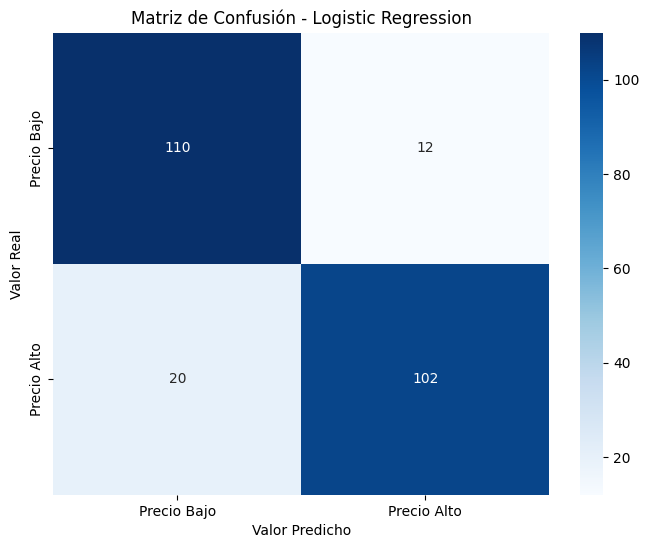


🎯 ENTRENANDO MODELO: Naive Bayes
------------------------------
📈 RESULTADOS ENTRENAMIENTO:

📊 MÉTRICAS DETALLADAS - NAIVE BAYES - ENTRENAMIENTO
Exactitud: 1.0000
Precisión: 1.0000
Recall: 1.0000
F1-Score: 1.0000

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       1.00      1.00      1.00       487
 Precio Alto       1.00      1.00      1.00       486

    accuracy                           1.00       973
   macro avg       1.00      1.00      1.00       973
weighted avg       1.00      1.00      1.00       973

📊 RESULTADOS PRUEBA:

📊 MÉTRICAS DETALLADAS - NAIVE BAYES - PRUEBA
Exactitud: 0.7336
Precisión: 0.7932
Recall: 0.7336
F1-Score: 0.7193
AUC-ROC: 0.7336

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.93      0.51      0.66       122
 Precio Alto       0.66      0.96      0.78       122

    accuracy                           0.73       244
   macro avg       0.79      0.7

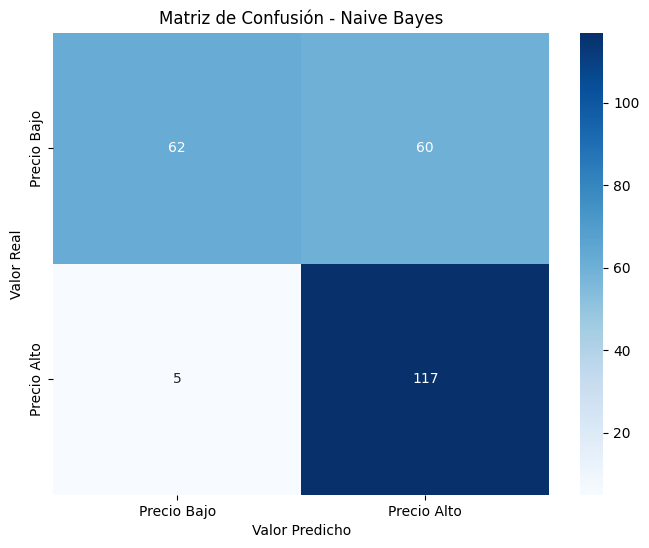


🎯 ENTRENANDO MODELO: LDA
------------------------------
📈 RESULTADOS ENTRENAMIENTO:

📊 MÉTRICAS DETALLADAS - LDA - ENTRENAMIENTO
Exactitud: 1.0000
Precisión: 1.0000
Recall: 1.0000
F1-Score: 1.0000

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       1.00      1.00      1.00       487
 Precio Alto       1.00      1.00      1.00       486

    accuracy                           1.00       973
   macro avg       1.00      1.00      1.00       973
weighted avg       1.00      1.00      1.00       973

📊 RESULTADOS PRUEBA:

📊 MÉTRICAS DETALLADAS - LDA - PRUEBA
Exactitud: 0.8238
Precisión: 0.8357
Recall: 0.8238
F1-Score: 0.8222
AUC-ROC: 0.8238

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.90      0.73      0.81       122
 Precio Alto       0.77      0.92      0.84       122

    accuracy                           0.82       244
   macro avg       0.84      0.82      0.82       244
we

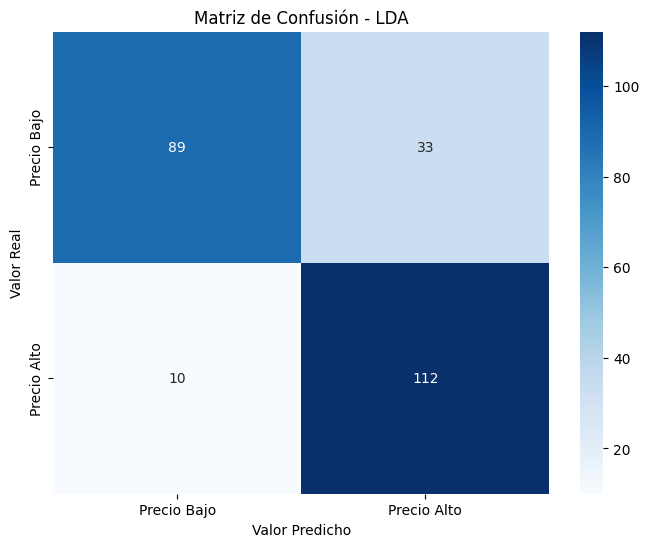


🎯 ENTRENANDO MODELO: Decision Tree
------------------------------
📈 RESULTADOS ENTRENAMIENTO:

📊 MÉTRICAS DETALLADAS - DECISION TREE - ENTRENAMIENTO
Exactitud: 1.0000
Precisión: 1.0000
Recall: 1.0000
F1-Score: 1.0000

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       1.00      1.00      1.00       487
 Precio Alto       1.00      1.00      1.00       486

    accuracy                           1.00       973
   macro avg       1.00      1.00      1.00       973
weighted avg       1.00      1.00      1.00       973

📊 RESULTADOS PRUEBA:

📊 MÉTRICAS DETALLADAS - DECISION TREE - PRUEBA
Exactitud: 0.9959
Precisión: 0.9959
Recall: 0.9959
F1-Score: 0.9959
AUC-ROC: 0.9959

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.99      1.00      1.00       122
 Precio Alto       1.00      0.99      1.00       122

    accuracy                           1.00       244
   macro avg       1.00   

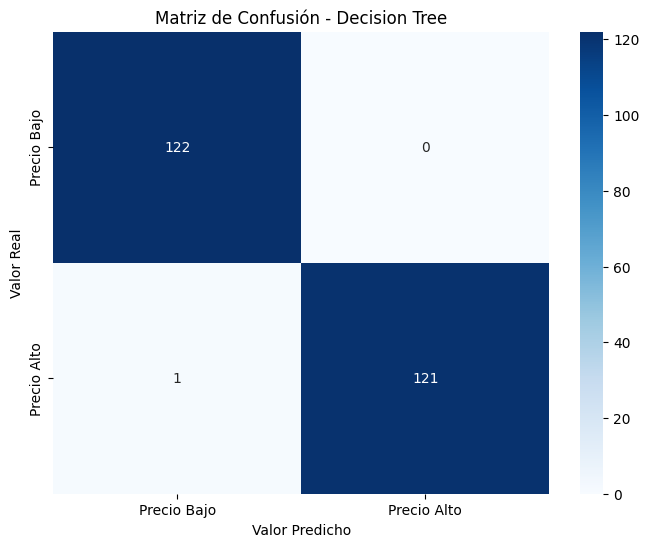


🎯 ENTRENANDO MODELO: K-Neighbors
------------------------------
📈 RESULTADOS ENTRENAMIENTO:

📊 MÉTRICAS DETALLADAS - K-NEIGHBORS - ENTRENAMIENTO
Exactitud: 0.9250
Precisión: 0.9259
Recall: 0.9250
F1-Score: 0.9249

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.91      0.95      0.93       487
 Precio Alto       0.95      0.90      0.92       486

    accuracy                           0.92       973
   macro avg       0.93      0.92      0.92       973
weighted avg       0.93      0.92      0.92       973

📊 RESULTADOS PRUEBA:

📊 MÉTRICAS DETALLADAS - K-NEIGHBORS - PRUEBA
Exactitud: 0.8607
Precisión: 0.8631
Recall: 0.8607
F1-Score: 0.8604
AUC-ROC: 0.9408

📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

 Precio Bajo       0.83      0.90      0.87       122
 Precio Alto       0.89      0.82      0.85       122

    accuracy                           0.86       244
   macro avg       0.86      0.8

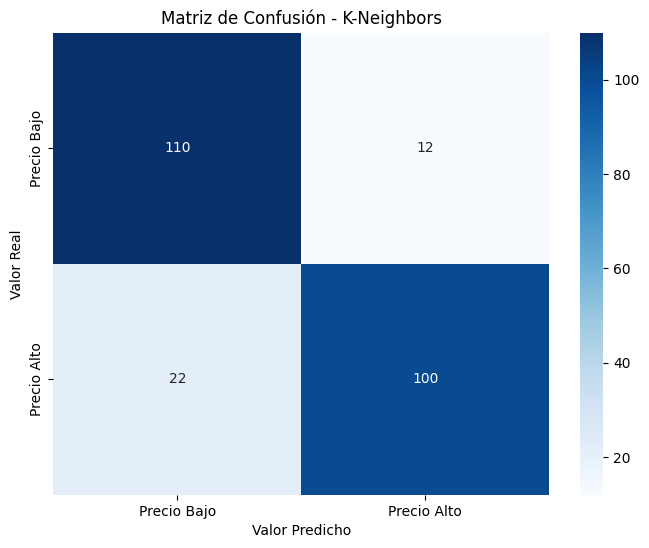


🏆 COMPARACIÓN DE MODELOS - CLASIFICACIÓN
             Modelo  Exactitud Test  Precisión Test  Recall Test  F1-Score Test  AUC-ROC Test
      Decision Tree        0.995902        0.995935     0.995902       0.995902      0.995902
      Random Forest        0.934426        0.934543     0.934426       0.934422      0.988713
                SVM        0.881148        0.883233     0.881148       0.880986      0.958009
Logistic Regression        0.868852        0.870445     0.868852       0.868711      0.951492
        K-Neighbors        0.860656        0.863095     0.860656       0.860421      0.940775
                LDA        0.823770        0.835702     0.823770       0.822191      0.823770
        Naive Bayes        0.733607        0.793195     0.733607       0.719347      0.733607

🔝 MEJORES MODELOS SELECCIONADOS:
REGRESIÓN: Linear Regression
CLASIFICACIÓN: Decision Tree

💾 Modelos guardados exitosamente:
  - mejor_modelo_regresion_Linear_Regression.pkl
  - mejor_modelo_clasificacion

In [31]:
# ============================================================
# 🔧 PARTE 10/10: MÉTODOS FINALES Y EJECUCIÓN PRINCIPAL
# ============================================================
import os
import json
from dotenv import load_dotenv
from datetime import datetime
import joblib
import pandas as pd
import numpy as np

def cargar_datos(self):
    """Carga y muestra información básica del dataset"""
    self.df = pd.read_csv(self.ruta_dataset)
    print(f"Dataset cargado: {self.df.shape[0]} filas × {self.df.shape[1]} columnas")

def predecir_nuevo_auto(self, mejor_modelo_reg, mejor_modelo_clf, columnas_numericas, columnas_categoricas):
    """Realiza predicciones para un nuevo automóvil"""
    nuevo_auto = self.crear_interfaz_entrada(columnas_numericas, columnas_categoricas)

    # Realizar predicciones
    precio_predicho_log = mejor_modelo_reg.predict(nuevo_auto)[0]
    categoria_predicha = mejor_modelo_clf.predict(nuevo_auto)[0]

    # Convertir de vuelta a escala original (asumiendo transformación logarítmica)
    precio_predicho = np.exp(precio_predicho_log)

    print(f"\n🎯 RESULTADOS DE PREDICCIÓN:")
    print("="*30)
    print(f"Precio predicho: ${precio_predicho:,.2f}")
    print(f"Categoría predicha: {'Precio Alto' if categoria_predicha == 1 else 'Precio Bajo'}")

    if hasattr(mejor_modelo_clf, 'predict_proba'):
        proba_alto = mejor_modelo_clf.predict_proba(nuevo_auto)[0][1]
        print(f"Probabilidad de precio alto: {proba_alto:.2%}")

    return precio_predicho, categoria_predicha

def guardar_mejores_modelos(self, mejor_modelo_reg, mejor_modelo_clf, nombre_reg, nombre_clf):
    """Guarda los mejores modelos entrenados"""
    reg_path = os.getenv("MODEL_REG_PATH", f"mejor_modelo_regresion_{nombre_reg}.pkl")
    clf_path = os.getenv("MODEL_CLF_PATH", f"mejor_modelo_clasificacion_{nombre_clf}.pkl")

    joblib.dump(mejor_modelo_reg, reg_path)
    joblib.dump(mejor_modelo_clf, clf_path)

    print(f"\n💾 Modelos guardados exitosamente:")
    print(f"  - {reg_path}")
    print(f"  - {clf_path}")

    # Guardar metadata en JSON
    metadata = {
        "dataset": {
            "ruta": self.ruta_dataset,
            "filas": int(self.df.shape[0]),
            "columnas": int(self.df.shape[1]),
            "columnas_numericas": [c for c in self.df.select_dtypes(include=np.number).columns],
            "columnas_categoricas": [c for c in self.df.select_dtypes(exclude=np.number).columns]
        },
        "modelos": {
            "regresion": {
                "nombre": nombre_reg,
                "ruta": reg_path
            },
            "clasificacion": {
                "nombre": nombre_clf,
                "ruta": clf_path
            }
        },
        "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d"),
        "autor": "AutomovilesModelEnhanced"
    }

    metadata_path = os.getenv("METADATA_PATH", "modelo_metadata.json")
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, indent=4, ensure_ascii=False)

    print(f"📄 Metadata guardada en: {metadata_path}")

def ejecutar_analisis_completo(self):
    """Ejecuta el análisis completo de principio a fin"""
    print("🎯 INICIANDO ANÁLISIS COMPLETO MEJORADO")

    # 1. Carga de datos
    self.cargar_datos()

    # 2. Preparación de datos
    (X, y_reg, y_clf, cols_num, cols_cat) = self.preparar_datos()

    # 3. Preprocesamiento
    preprocesador = self.crear_pipeline_preprocesamiento(cols_num, cols_cat)

    # 4. División de datos
    (X_train_reg, X_test_reg, y_train_reg, y_test_reg,
     X_train_clf, X_test_clf, y_train_clf, y_test_clf) = self.dividir_datos(X, y_reg, y_clf)

    # 5. Modelado de regresión
    print(f"\n{'='*60}")
    print(f"🎯 MODELOS DE REGRESIÓN - Comparación Múltiple")
    print(f"{'='*60}")

    self.modelos_regresion = self.crear_modelos_regresion(preprocesador)
    resultados_regresion = self.evaluar_modelos_regresion(
        self.modelos_regresion, X_train_reg, y_train_reg, X_test_reg, y_test_reg)

    comparacion_regresion = self.comparar_modelos_regresion(resultados_regresion)

    # 6. Modelado de clasificación
    print(f"\n{'='*60}")
    print(f"🎯 MODELOS DE CLASIFICACIÓN - Comparación Múltiple")
    print(f"{'='*60}")

    self.modelos_clasificacion = self.crear_modelos_clasificacion(preprocesador)
    resultados_clasificacion = self.evaluar_modelos_clasificacion(
        self.modelos_clasificacion, X_train_clf, y_train_clf, X_test_clf, y_test_clf)

    comparacion_clasificacion = self.comparar_modelos_clasificacion(resultados_clasificacion)

    # 7. Seleccionar mejores modelos
    mejor_nombre_reg = comparacion_regresion.iloc[0]['Modelo']
    mejor_nombre_clf = comparacion_clasificacion.iloc[0]['Modelo']

    self.mejor_modelo_reg = resultados_regresion[mejor_nombre_reg]['modelo']
    self.mejor_modelo_clf = resultados_clasificacion[mejor_nombre_clf]['modelo']

    print(f"\n🔝 MEJORES MODELOS SELECCIONADOS:")
    print(f"REGRESIÓN: {mejor_nombre_reg}")
    print(f"CLASIFICACIÓN: {mejor_nombre_clf}")

    # 9. Guardar mejores modelos + metadata
    self.guardar_mejores_modelos(self.mejor_modelo_reg, self.mejor_modelo_clf,
                                mejor_nombre_reg.replace(' ', '_'),
                                mejor_nombre_clf.replace(' ', '_'))

    # 10. Resumen final
    print(f"\n{'='*80}")
    print(f"✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
    print(f"{'='*80}")

    return {
        'mejor_modelo_reg': self.mejor_modelo_reg,
        'mejor_modelo_clf': self.mejor_modelo_clf,
        'comparacion_regresion': comparacion_regresion,
        'comparacion_clasificacion': comparacion_clasificacion
    }

# ============================================================
# 👉 AÑADIR MÉTODOS A LA CLASE EXISTENTE
# ============================================================
AutomovilesModelEnhanced.cargar_datos = cargar_datos
AutomovilesModelEnhanced.predecir_nuevo_auto = predecir_nuevo_auto
AutomovilesModelEnhanced.guardar_mejores_modelos = guardar_mejores_modelos
AutomovilesModelEnhanced.ejecutar_analisis_completo = ejecutar_analisis_completo

# ============================================================
# 🚀 EJECUCIÓN PRINCIPAL
# ============================================================
if __name__ == "__main__":
    load_dotenv()  # cargar .env
    ruta_dataset = os.getenv("DATASET_PATH")
    analisis = AutomovilesModelEnhanced(ruta_dataset)
    resultados_finales = analisis.ejecutar_analisis_completo()



#SEGUNDA PARTE 

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    KFold,
    LeaveOneOut,
    cross_val_score,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna
from joblib import dump
import os
# from .utils import get_dataset_path, get_model_path
# Use DATA_PATH and define get_model_path inline for notebook context
def get_dataset_path():
    return DATA_PATH

def get_model_path():
    return "mejor_modelo.joblib"

# === Carga y preprocesamiento ===
def load_and_preprocess():
    df = pd.read_csv(get_dataset_path())
    # Eliminar columnas innecesarias o duplicadas
    cols_to_drop = ['id', 'Brands', 'Model', 'Engines', 'HorsePower_in_HP_2',
                    'Torque_in_Nm_2', 'Price_Max']
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Codificar variables categóricas
    df = pd.get_dummies(df, columns=['Fuel_1'], drop_first=True)
    
    # Separar X e y
    X = df.drop(columns=['Price_Min'])
    y = df['Price_Min']
    
    # Eliminar filas con NaN en y
    mask = y.notna()
    X, y = X[mask], y[mask]
    
    # Rellenar NaN en X con mediana
    X = X.fillna(X.median(numeric_only=True))
    
    return X, y

# === Modelos ===
def train_gradient_boosting(X_train, y_train):
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBRegressor(random_state=42, eval_metric='rmse')
    model.fit(X_train, y_train)
    return model

# === Validación cruzada ===
def evaluate_model_cv(model, X, y, cv_type='kfold'):
    if cv_type == 'kfold':
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
    elif cv_type == 'loo':
        cv = LeaveOneOut()
    else:
        raise ValueError("cv_type debe ser 'kfold' o 'loo'")
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# === Optimización con GridSearch ===
def optimize_gb_grid(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
    gb = GradientBoostingRegressor(random_state=42)
    grid = GridSearchCV(gb, param_grid, cv=3, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)
    return grid.best_estimator_

# === Optimización con RandomizedSearch ===
def optimize_xgb_random(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    xgb = XGBRegressor(random_state=42)
    rand = RandomizedSearchCV(xgb, param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error')
    rand.fit(X_train, y_train)
    return rand.best_estimator_

# === Optimización Bayesiana con Optuna ===
def objective_xgb(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'eval_metric': 'rmse'
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_train)
    return np.sqrt(mean_squared_error(y_train, preds))

def optimize_xgb_optuna(X_train, y_train):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective_xgb(trial, X_train, y_train), n_trials=20)
    best_params = study.best_params
    best_model = XGBRegressor(**best_params, random_state=42, eval_metric='rmse')
    best_model.fit(X_train, y_train)
    return best_model

# === Entrenamiento principal ===
def main():
    X, y = load_and_preprocess()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar modelos base
    gb_base = train_gradient_boosting(X_train, y_train)
    xgb_base = train_xgboost(X_train, y_train)

    # Evaluar con CV
    print("GB RMSE (KFold):", evaluate_model_cv(gb_base, X, y, 'kfold'))
    print("XGB RMSE (KFold):", evaluate_model_cv(xgb_base, X, y, 'kfold'))

    # Optimización
    print("Optimizando con GridSearch (GB)...")
    gb_opt = optimize_gb_grid(X_train, y_train)

    print("Optimizando con RandomizedSearch (XGB)...")
    xgb_rand = optimize_xgb_random(X_train, y_train)

    print("Optimizando con Optuna (XGB)...")
    xgb_optuna = optimize_xgb_optuna(X_train, y_train)

    # Evaluar modelos optimizados
    models = {
        "GB_Grid": gb_opt,
        "XGB_Random": xgb_rand,
        "XGB_Optuna": xgb_optuna
    }

    best_model = None
    best_score = float('inf')
    for name, model in models.items():
        score = evaluate_model_cv(model, X, y, 'kfold')
        print(f"{name} RMSE (KFold): {score:.2f}")
        if score < best_score:
            best_score = score
            best_model = model

    # Guardar mejor modelo
    model_path = get_model_path()
    dir_name = os.path.dirname(model_path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)
    dump(best_model, model_path)
    print(f"Mejor modelo guardado en: {model_path}")

# En Jupyter Notebook no se usa el bloque if __name__ == "__main__":.
# Simplemente llama a la función main() para ejecutar el flujo principal.

main()

GB RMSE (KFold): 447523.7986621425
XGB RMSE (KFold): 442448.1170509908
Optimizando con GridSearch (GB)...
Optimizando con RandomizedSearch (XGB)...


[I 2025-09-26 15:32:05,326] A new study created in memory with name: no-name-79f90b89-acb0-4a3a-b45b-b7dc0c357dba


Optimizando con Optuna (XGB)...


[I 2025-09-26 15:32:05,541] Trial 0 finished with value: 391390.6465475571 and parameters: {'n_estimators': 108, 'max_depth': 7, 'learning_rate': 0.24236586318862224, 'subsample': 0.6080194546602994, 'colsample_bytree': 0.9116433540442198}. Best is trial 0 with value: 391390.6465475571.
[I 2025-09-26 15:32:06,447] Trial 1 finished with value: 388891.71680624277 and parameters: {'n_estimators': 351, 'max_depth': 9, 'learning_rate': 0.06407939167695713, 'subsample': 0.8471923338449628, 'colsample_bytree': 0.6482226565295071}. Best is trial 1 with value: 388891.71680624277.
[I 2025-09-26 15:32:06,755] Trial 2 finished with value: 392290.22431342036 and parameters: {'n_estimators': 193, 'max_depth': 6, 'learning_rate': 0.06982176620693248, 'subsample': 0.6150574631912075, 'colsample_bytree': 0.9450497742185258}. Best is trial 1 with value: 388891.71680624277.
[I 2025-09-26 15:32:07,034] Trial 3 finished with value: 390562.56145850546 and parameters: {'n_estimators': 228, 'max_depth': 4, 'l

GB_Grid RMSE (KFold): 445125.99
XGB_Random RMSE (KFold): 450167.84
XGB_Optuna RMSE (KFold): 446299.16
Mejor modelo guardado en: mejor_modelo.joblib


In [34]:
import pandas as pd
from datetime import datetime
import os

FEEDBACK_FILE = "data/feedback_new_data.csv"

def log_feedback(input_data: dict, predicted_price: float, actual_price: float = None):
    """
    input_data: dict con las mismas columnas que el dataset original (sin id, Price_Min, Price_Max)
    predicted_price: valor predicho por el modelo
    actual_price: opcional, si el usuario reporta el precio real
    """
    record = input_data.copy()
    record['predicted_price'] = predicted_price
    record['actual_price'] = actual_price
    record['timestamp'] = datetime.now().isoformat()

    df = pd.DataFrame([record])
    if os.path.exists(FEEDBACK_FILE):
        df.to_csv(FEEDBACK_FILE, mode='a', header=False, index=False)
    else:
        df.to_csv(FEEDBACK_FILE, index=False)

    print("Feedback registrado para reentrenamiento futuro.")